In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
dat = "GZZ_data4.jld"
X = load(dat, "X")
y = load(dat, "y")
ξ_true = load(dat, "xi_true");

d, Nobs = size(X)
mb_size = Int(round(Nobs/10))
σ02 = 1
prior = GDP_prior(d, σ02)

GDP_prior(200, 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.0, 1.0, 1.0, 1.0, 1.0)

In [3]:
ξ_true[ξ_true .!= 0]

20-element Array{Float64,1}:
  1.33924
  9.5744 
 -5.25388
  8.94001
  7.34624
  7.46383
 -6.15703
 -4.95826
 -3.82624
 -4.29341
 -7.46248
 -5.90982
 -7.20435
 -3.48888
 11.6262 
 -3.39109
 -6.47746
  9.89104
  7.36636
 -5.12442

In [4]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [5]:
# Sub-Sampling without control variate and with weights
ϵ = 1e-2
weights = abs.(X) + ϵ
weights ./= sum(weights,2)
gs = [wumbsampler(Nobs, mb_size, weights[i,:]) for i in 1:d]
gs_list = mbsampler_list(d,gs);

In [27]:
A = eye(d)

opf = projopf(A, 1000, hyperparam_size(prior))
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [28]:
adapt_speed = false
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e2)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [29]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

10% attempts in 0.52 mins 
20% attempts in 1.16 mins 
30% attempts in 1.78 mins 
40% attempts in 2.47 mins 
50% attempts in 3.18 mins 
60% attempts in 3.9 mins 
70% attempts in 4.66 mins 
80% attempts in 5.4 mins 
90% attempts in 6.16 mins 
100% attempts in 6.97 mins 
6.97 mins

In [30]:
zz_bounces = sum(zz_state(outp.opf).n_bounces)
hyp_bounces = outp.opf.tcounter-sum(zz_state(outp.opf).n_bounces)
@printf("ZZ bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ bounces: 228751, hyper bounces: 7067

In [31]:
size(outp.opf.xi_skeleton)

(200, 235818)

In [32]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear")[:,1:end-1];
hyp_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                              outp.opf.bt_skeleton[:,discard+1:end], 
                              outp.opf.bt_skeleton[end]/n_samples,
                              "constant")[:,1:end-1];

In [33]:
effort_gzz = outp.opt.max_attempts*d + zz_bounces*1*mb_size + hyp_bounces*d
effort_hmc = 10^4*100*Nobs*d
print(effort_hmc/effort_gzz)

379.933002614319

In [34]:
maxlag = 200
acfs_xi = zeros(d, maxlag)
acfs_hyp = zeros(size(hyp_samples,1), maxlag)

for i in 1:d 
    acfs_xi[i,:] = acf(xi_samples[i,:], maxlag)
end
for i in 1:size(hyp_samples,1)
    acfs_hyp[i,:] = acf(hyp_samples[i,:], maxlag)
end

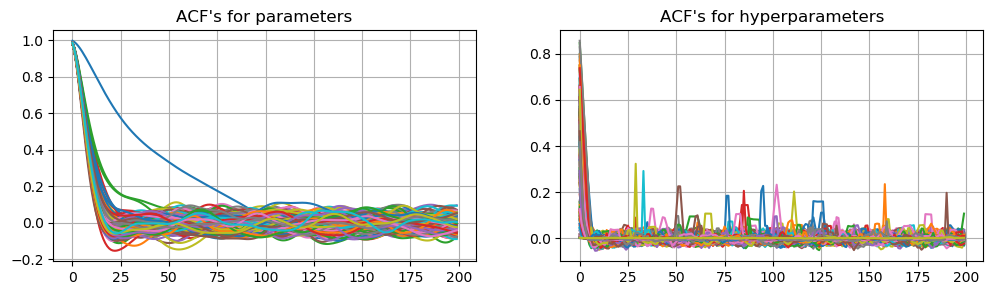

In [35]:
fig = figure("pyplot_subplot_mixed", figsize=(12,3))
subplot(121)
for i in 1:d 
    plot(acfs_xi[i,:])
end
grid(true)
title("ACF's for parameters")

subplot(122)
for i in 1:size(hyp_samples,1) 
    plot(acfs_hyp[i,:])
end
grid(true)
title("ACF's for hyperparameters");

In [25]:
cover = zeros(d)
ci = zeros(d,2)
for i in 1:d 
    ci[i,:] = percentile(xi_samples[i,:], [5, 95])
    cover[i] = (ci[i,1]<ξ_true[i])&(ξ_true[i]<ci[i,2])
end

In [26]:
100*mean(cover)

90.0